<a href="https://colab.research.google.com/github/oconcito8/deepLearning/blob/master/Entrega%20LAB3%20IA%20Generativa%20-%20Im%C3%A1genes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Práctica LAB3 IA Generativa - Imágenes

Autor: Carlos Ocón/ Pedro García.

Deep learning





Ejercicio 1: Entrenar un Variational Autoencoder con la base de dados keras.datasets.fashion_mnist (con las imágenes de Zalando). Una vez que entrenado el modelo, usar la red decoder para convertir vectores espaciales latentes arbitrarios en imágenes. (Mostrar un ejemplo del espacio latente)


Primero importamos la librería que tiene los datos con los que vamos a trabajar.

In [ ]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist

# Load the dataset
(train_img, train_labels), (test_img, test_labels) = fashion_mnist.load_data()




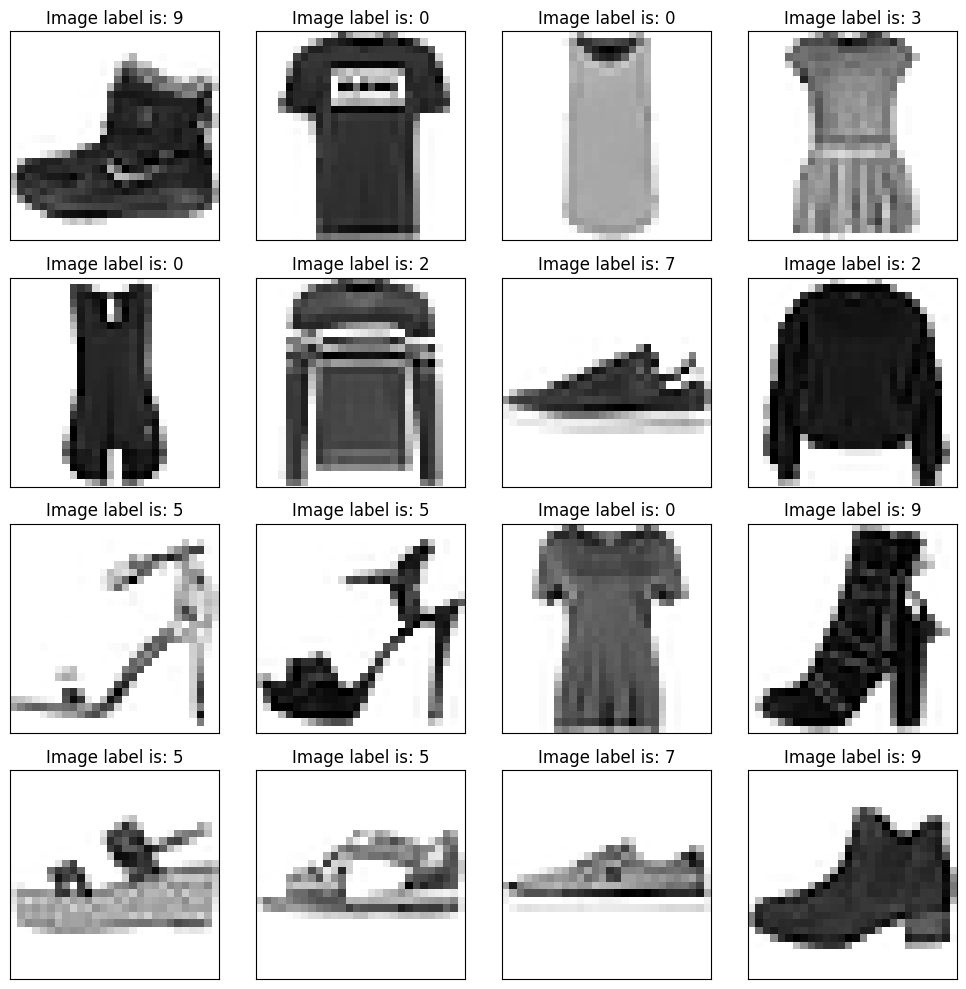

In [ ]:
def plot_images(images, labels, num_rows=4, num_cols=4, cmap='binary'):
    """Plot a grid of images with their labels."""
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the grid for easy iteration

    for i, ax in enumerate(axes):
        if i < len(images):
            # Display image
            ax.imshow(images[i], cmap=cmap)
            # Display label
            ax.set_title(f"Image label is: {labels[i]}")

        # Remove ticks and labels from axes
        ax.set_xticks([])
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()
    plt.show()

# Usage example with corrected variable names
plot_images(train_img, train_labels)

**Red encoder VAE**

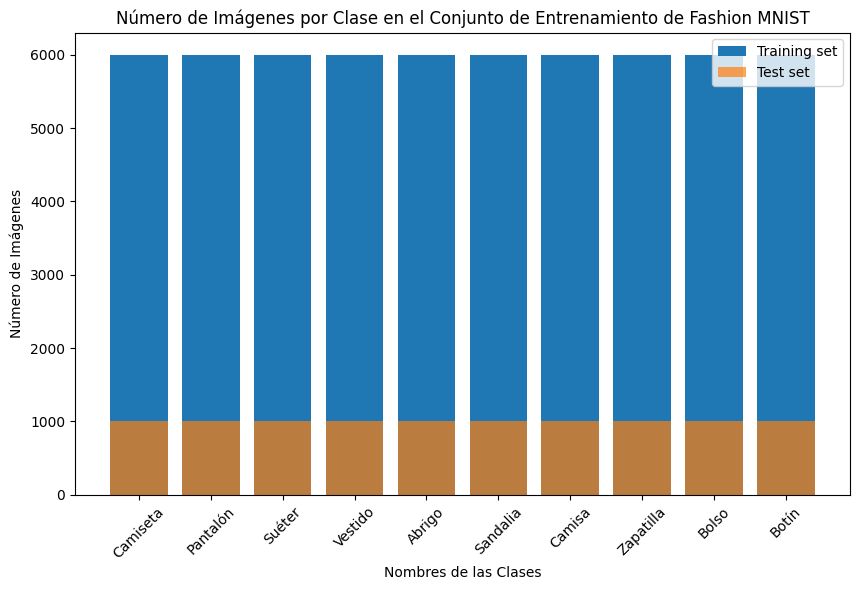

Número de prendas en el conjunto de entrenamiento: 60000


In [ ]:
# Count occurrences of each label in the training dataset
unique, counts = np.unique(train_labels, return_counts=True)
train_label_counts = dict(zip(unique, counts))

# Optionally, count labels in the test dataset
unique_test, counts_test = np.unique(test_labels, return_counts=True)
test_label_counts = dict(zip(unique_test, counts_test))

# Updated class names for labels from 0 to 9
class_names = ['Camiseta', 'Pantalón', 'Suéter', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Botín']

# Create a bar chart for the training set
plt.figure(figsize=(10, 6))
plt.bar(class_names, [train_label_counts[i] for i in unique], label='Training set')

# Optionally, create a bar chart for the test set
plt.bar(class_names, [test_label_counts[i] for i in unique_test], label='Test set', alpha=0.7)

plt.xlabel('Nombres de las Clases')
plt.ylabel('Número de Imágenes')
plt.title('Número de Imágenes por Clase en el Conjunto de Entrenamiento de Fashion MNIST')
plt.xticks(rotation=45)
plt.legend()
plt.show()
# Muestra el número de imágenes en el conjunto de entrenamiento
print("Número de prendas en el conjunto de entrenamiento:", len(train_img))
print("Número de prendas en el conjunto de entrenamiento:", len(test_img))

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# Dimensionalidad del espacio latente: un plano 2D
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
# La imagen de entrada termina siendo codificada
# en estos dos parámetros: z_mean y z_log_var
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [ ]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        # Dibuja un lote de vectores normales aleatorios.
        epsilon = tf.random.normal(shape=(batch_size, z_size))
        # Aplicar la fórmula de muestreo VAE
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Entrada a través de la cual alimentaremos con z
latent_inputs = keras.Input(shape=(latent_dim,))
# Producimos la misma cantidad de coeficientes que
# teníamos al nivel de la capa Flatten en el codificador.
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# Revertimos la capa Flatten del codificador.
x = layers.Reshape((7, 7, 64))(x)
# Revertimos las capas Conv2D del codificador.
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# La salida termina con la forma (28, 28, 1)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         289 

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # Usamos estas métricas para realizar un seguimiento
        # de los promedios de pérdida en cada época.
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # Listamos las métricas en la propiedad metrics para permitir
    # que el modelo las restablezca después de cada época (o entre
    # varias llamadas a fit()/evaluate())
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sumamos la pérdida de reconstrucción sobre las
            # dimensiones espaciales (ejes 1 y 2) y tomamos
            # su media sobre la dimensión del lote.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # Agreguamos el término de regularización
            # (divergencia de Kullback-Leibler).
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# Entrenamos en todos los dígitos MNIST, por lo que
# concatenamos las muestras de entrenamiento y prueba.
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# Notemos que no pasamos un argumento de pérdida a compile(),
# ya que la pérdida ya es parte de train_step()
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True)
# Notemos que no pasamos objetivos (targets) en fit(),
# ya que train_step() no espera ninguno
vae.fit(mnist_digits, epochs=30, batch_size=128)

11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 291s 531ms/step - total_loss: 199.9723 - reconstruction_loss: 197.2154 - kl_loss: 2.7570
Epoch 2/30
547/547 [==============================] - 286s 523ms/step - total_loss: 162.4394 - reconstruction_loss: 159.5044 - kl_loss: 2.9349
Epoch 3/30
547/547 [==============================] - 261s 477ms/step - total_loss: 155.6839 - reconstruction_loss: 152.4744 - kl_loss: 3.2095
Epoch 4/30
547/547 [==============================] - 256s 468ms/step - total_loss: 153.0327 - reconstruction_loss: 149.7128 - kl_loss: 3.3200
Epoch 5/30
547/547 [==============================] - 251s 460ms/step - total_loss: 151.3526 - reconstruction_loss: 147.9754 - kl_loss: 3.3772
Epoch 6/30
547/547 [==============================] - 269s 492ms/step - total_loss: 150.1608 - reconstruction_loss: 146.7279 - kl_loss: 3.4329
Epoch 7/30
547/547 [==============================] - 252s 461ms/step - total

1/1 [==============================] - 0s 28ms/step


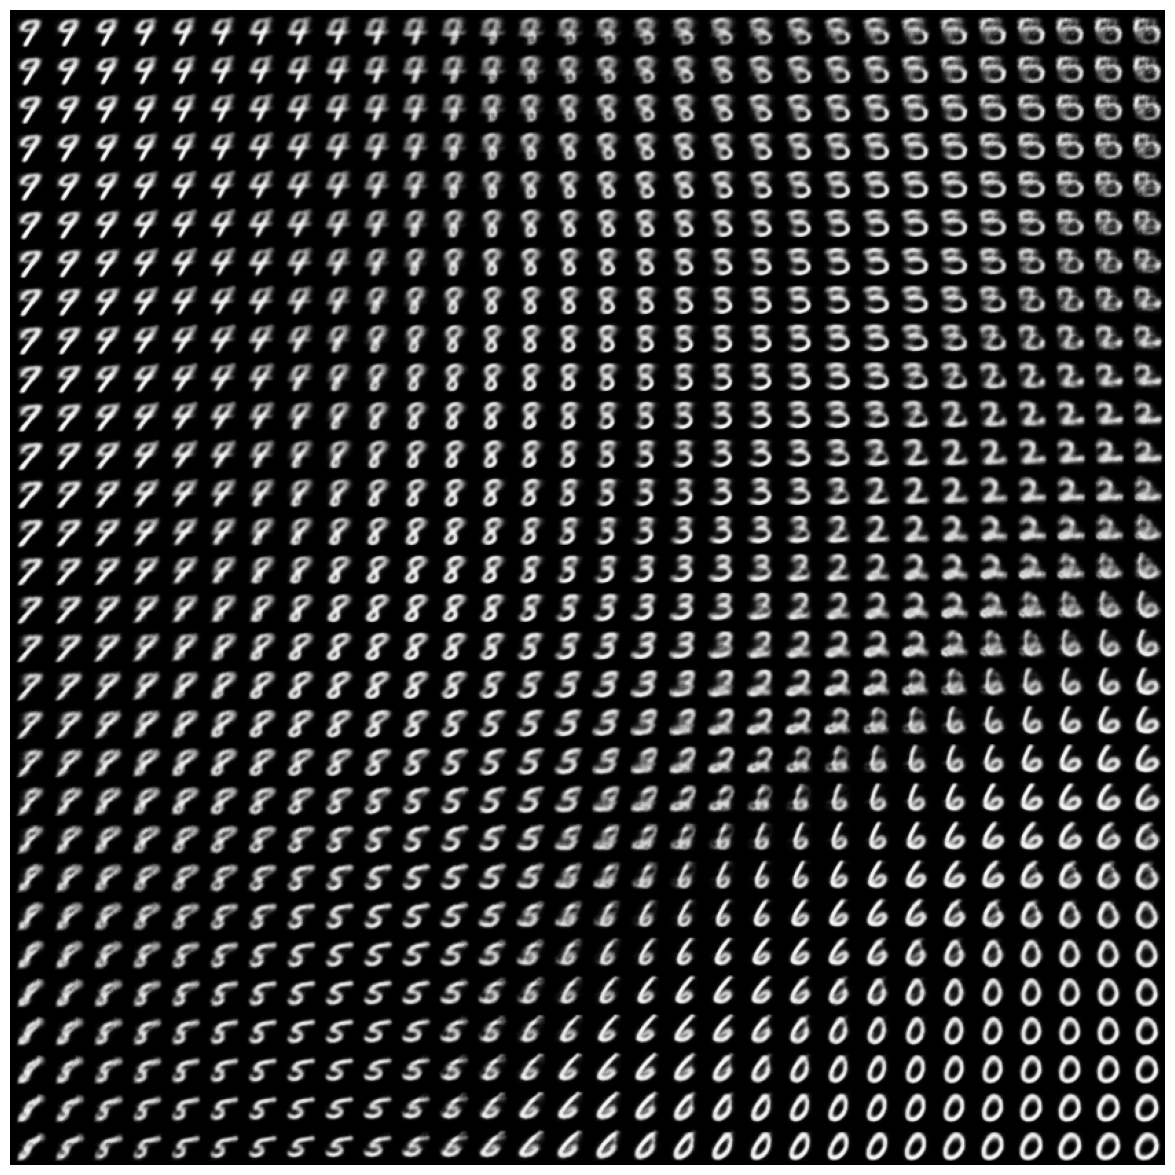

In [ ]:
import matplotlib.pyplot as plt

# Mostraremos una cuadrícula de
# 30 × 30 dígitos (900 dígitos en total)
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Muestree de puntos linealmente en una cuadrícula 2D.
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # Para cada ubicación, muestreamos un
        # dígito y lo agregamos a nuestra figura
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

# **EJERCICIO 2**


Dada la siguiente base de datos de zapatos (https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip). Entrenar una GAN para generar imágenes de zapatos nuevas.

**Obteniendo los datos de CelebA**

In [ ]:
# Creamos el directorio de trabajo
!mkdir zapatos_gan

# Descargamos los datos directamente desde la URL
!wget https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip -O zapatos_gan/data.zip

# Descomprimimos los datos
!unzip -qq zapatos_gan/data.zip -d zapatos_gan

mkdir: cannot create directory ‘zapatos_gan’: File exists
--2024-05-13 16:53:32--  https://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images-square.zip
Resolving vision.cs.utexas.edu (vision.cs.utexas.edu)... 128.83.130.185
Connecting to vision.cs.utexas.edu (vision.cs.utexas.edu)|128.83.130.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144233542 (138M) [application/zip]
Saving to: ‘zapatos_gan/data.zip’

zapatos_gan/data.zi 100%[===================>] 137.55M  94.8MB/s    in 1.5s    

2024-05-13 16:53:34 (94.8 MB/s) - ‘zapatos_gan/data.zip’ saved [144233542/144233542]

replace zapatos_gan/ut-zap50k-images-square/Boots/Ankle/A. Testoni/7965307.5291.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Usamos **``image_dataset_from_directory`` para convertirlo en un dataset.** Dado que **solo necesitamos las imágenes, no hay etiquetas**, especificaremos **``label_mode=None``**.

**Creamos un dataset a partir de un directorio de imágenes**

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "zapatos_gan",
    # Solo se devolverán las imágenes, sin etiquetas.
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    # Cambiaremos el tamaño de las imágenes a 64 × 64
    # usando una combinación inteligente de recorte y
    # cambio de tamaño para preservar la relación de
    # aspecto.
    smart_resize=True)

Found 50066 files belonging to 1 classes.


Finalmente, cambiamos la **escala de las imágenes al rango ``[0-1]``**

**Rescalamos las imágenes**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

**Mostramos la primera imagen**

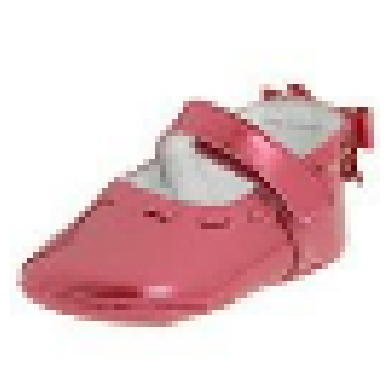

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### El discriminator

**Modelo ``discriminator``**: **toma** como entrada una **imagen candidata** (real o sintética) **y la clasifica** en una de dos clases: **"generated image"** o **"real image that comes from the training set"**.

Uno de los muchos **problemas** que surgen comúnmente **con las GAN** es que el **generador se atasca con imágenes generadas que parecen ruido**. Una posible solución es **usar dropout en el discriminador**, eso es lo que haremos aquí.

**La red discriminadora (discriminator) GAN**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        # Una capa de Dropout: ¡un truco importante!
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### El generator

Modelo ``generator``: **convierta un vector** (desde el espacio latente; durante el entrenamiento se muestreará al azar) **en una imagen candidata**.

**La Red Generadora GAN**

In [ ]:
# El espacio latente estará formado por vectores de 128 dimensiones.
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # Producimos la misma cantidad de coeficientes que teníamos
        # al nivel de la capa Flatten en el codificador.
        layers.Dense(8 * 8 * 128),
        # Revertimos la capa Flatten del codificador
        layers.Reshape((8, 8, 128)),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # Revertimos las capas Conv2D del codificador.
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        # Usamos LeakyReLU como nuestra activación
        layers.LeakyReLU(alpha=0.2),
        # La salida termina con la forma (28, 28, 1)
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 128)       262272    
 anspose)                                                        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        # Configura métricas para rastrear las dos
        # pérdidas en cada época de entrenamiento
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Muestrea puntos aleatorios en el espacio latente
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # Los decodifica a imágenes falsas
        generated_images = self.generator(random_latent_vectors)
        # Los combina con imágenes reales
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Ensambla etiquetas, discriminando imágenes reales de falsas
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        # Agrega ruido aleatorio a las etiquetas: ¡un truco importante!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Entrenamos al discriminador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(
            # Muestrea puntos aleatorios en el espacio latente
            shape=(batch_size, self.latent_dim))

        # Ensambla etiquetas de imágenes reales
        misleading_labels = tf.zeros((batch_size, 1))

        # Entrena al generador
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**Antes** **de** comenzar a **entrenar**, **configuramos una callback para monitorizar nuestros resultados**: **usará el generador para crear y guardar una cantidad de imágenes falsas al final de cada época**.

**Una callback que muestra imágenes generadas durante el entrenamiento**

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

Finalmente, podemos comenzar a entrenar

**Compilando y entrenando la GAN**

In [ ]:
# Comenzaremos a obtener resultados interesantes después de la época 20.
epochs = 15

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/15
  17/1565 [..............................] - ETA: 15:09:42 - d_loss: 0.6237 - g_loss: 0.6276

In [ ]:

import matplotlib.pyplot as plt
from PIL import Image

# Ruta de las imágenes generadas en la última época
img1_path = "generated_img_{:03d}_0.png".format(epochs - 1)
img2_path = "generated_img_{:03d}_1.png".format(epochs - 1)

# Carga las imágenes usando PIL
img1 = Image.open(img1_path)
img2 = Image.open(img2_path)

# Crea una figura de matplotlib y muestra las imágenes
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.axis('off')
plt.title('Imagen Generada 1')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis('off')
plt.title('Imagen Generada 2')

plt.show()